# **DATA VISUALIZATION**

## Objectives

- Answer business requirement 1:
       The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy and that contains powdery mildew.
- This notebook also aims to validate Hypothesis 1:
We hypothesize that infected leaves have clear white marks with which they can be distinguished from healthy leaves


## Inputs

* inputs/cherry_dataset/cherry-leaves/train
* inputs/cherry_dataset/cherry-leaves/test
* inputs/cherry_dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file, in this case we already know that it will be 50 x 50.
* Mean and variability of the leaves images per both labels, and plot them.
* Plot to distinguish contrast between healthy and powdery mildew infected leaves images.
* Generate code that answers business requirement 1 and can be used to build image montage on Streamlit dashboard.

## Additional Comments

* After exploring the dataset, we notice that the images are 256 pixels × 256 pixels, that should be the image shape of the files, but the trained model will be very large, that is why we consider using an image shape of 50 x 50.

---

## **Set Data Directory**

### Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("whitegrid")
from matplotlib.image import imread

### Set working directory
Need to change the working directory from its current folder to its parent folder

* Access the current directory with os.getcwd()

In [4]:
cwd= os.getcwd()

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory


In [6]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [7]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

### Set input directories

* Set train, validation and test paths

In [8]:
my_data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

'inputs/cherry_dataset/cherry-leaves'

### Set output directory

* Create the output folder if it does not exists or a new version if the folder exists and the version number is new.

In [9]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available, please create a new version.


### Set label names

* Set the name of the labels, taken the names of the folders of the dataset as reference.

In [11]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


---
## **Data visualization of image data**

### Image shape

* Compute average images size on train set

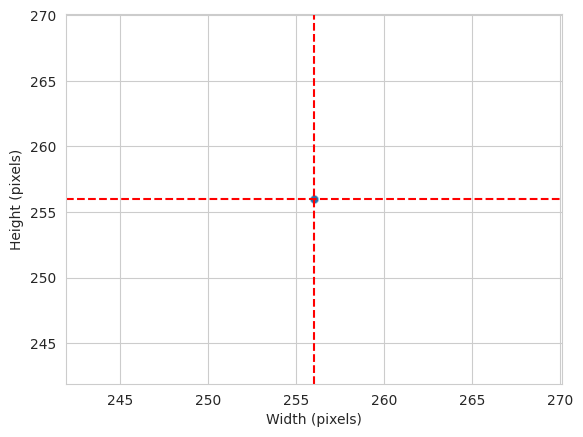

Width average: 256 
Height average: 256


In [12]:
dim1, dim2 = [], []
for label in labels:
  # iterate over each file of both folders and get height and width of the image
  # and append it to the respective array (dim1=height, dim2=width) 
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape # the shape give as an array with height, width and colors
    dim1.append(d1) # image height
    dim2.append(d2) # image width
# Using matplotlib.pyplot to create the figure and the axes of the plot
# Using seaborn to give the values to x and y
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


* All the images are 256 pixels × 256 pixels, that should be the image shape of the files, but the trained model will be very large, that is why we consider using an image shape of 50 x 50.


In [13]:
image_shape = (50, 50, 3)

* Save the image shape embeddings

In [14]:
joblib.dump(value=image_shape,
            filename = f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---
### Average and variability of images per label

* Function to load images in an array (tensor) using image module of keras library. The function uses default values for resizing the images and how many images per label are getting processed. These default values can be overridden when calling the function with the desired values as function arguments.

In [17]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size = (50,50), n_images_per_label=20):
    '''
    This function loads images from a directory and converts them into numpy arrays.

    Parameters:
        my_data_dir (str): The directory path containing the images.
        new_size (tuple): The new size to resize the images.
        n_images_per_label (int): The maximum number of images to load per label.
    
    Returns:
        X (numpy.ndarray): Array of image data.
        y (numpy.ndarray): Array of labels corresponding to the images.
    '''

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
          # n_images_per_label: we set a limit, since it may take too much time 
          if counter < n_images_per_label:
            img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size = new_size)
            if image.img_to_array(img).max() > 1:
                img_resized = image.img_to_array(img) / 255
            else:
                img_resized = image.img_to_array(img)

            X = np.append(X, img_resized).reshape(-1,new_size[0], new_size[1], img_resized.shape[2])
            y = np.append(y, label)
            counter += 1
    return X, y 

* Load image shapes and labels in array

In [18]:
X, y = load_image_as_array(my_data_dir=train_path, new_size=image_shape, n_images_per_label=30)

print(X.shape, y.shape)

(60, 50, 50, 3) (60,)


**Plot and save mean, variability of images per label**

* The function loops over all labels, subsets an array for a given label, calculates the mean and standard deviation, creates a figure displaying the mean and variability images and saves the image if desired.

In [45]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False, path_addition=''):
  """ 
   The pseudo code for the function is:
  - loop in all labels
  - subset an array for given label
  - calculate mean and standard deviation
  - create a figure displaying mean and variability of images
  - save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]
    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    # Save the image
    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label healthy ====
Image Shape: (50, 50, 3)
==== Label powdery_mildew ====
Image Shape: (50, 50, 3)


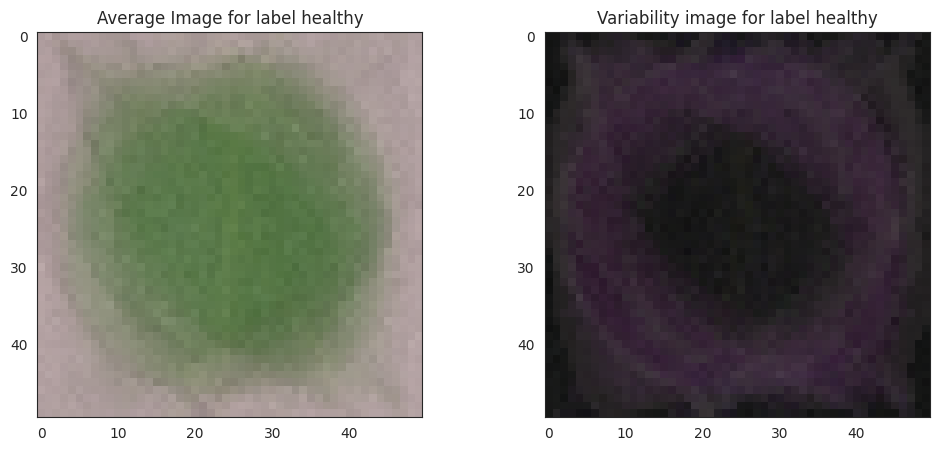

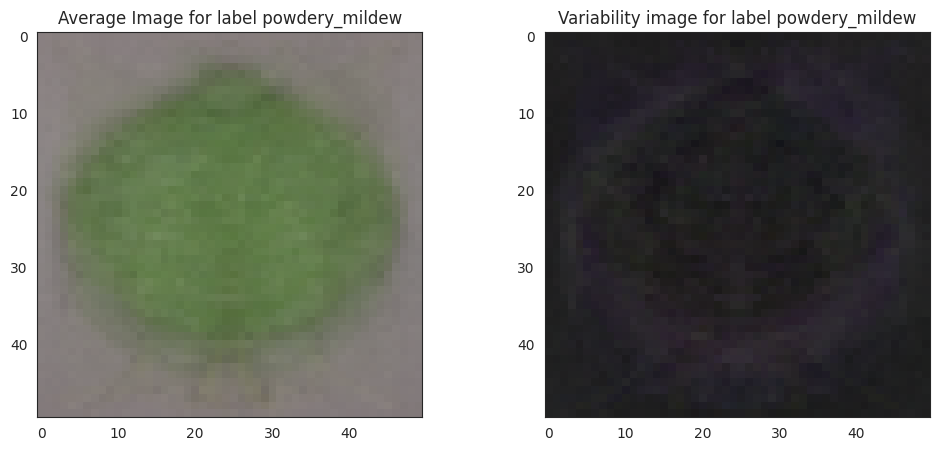

In [46]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)


**Checking average and variability images with a different image size**

- It is crucial to see if the images differ when using a different image size, so loaded the images with a size of 50x50

In [47]:
X, y = load_image_as_array(my_data_dir=train_path,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 50, 50, 3) (60,)


==== Label healthy ====
Image Shape: (50, 50, 3)
==== Label powdery_mildew ====
Image Shape: (50, 50, 3)


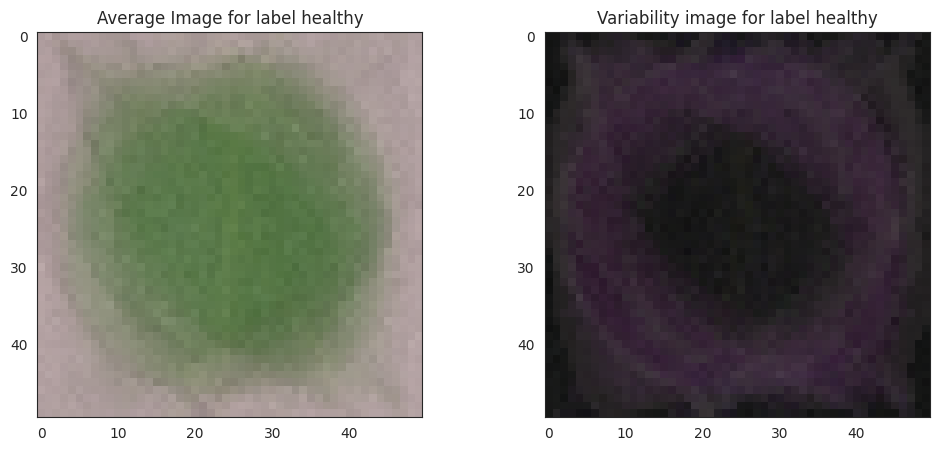

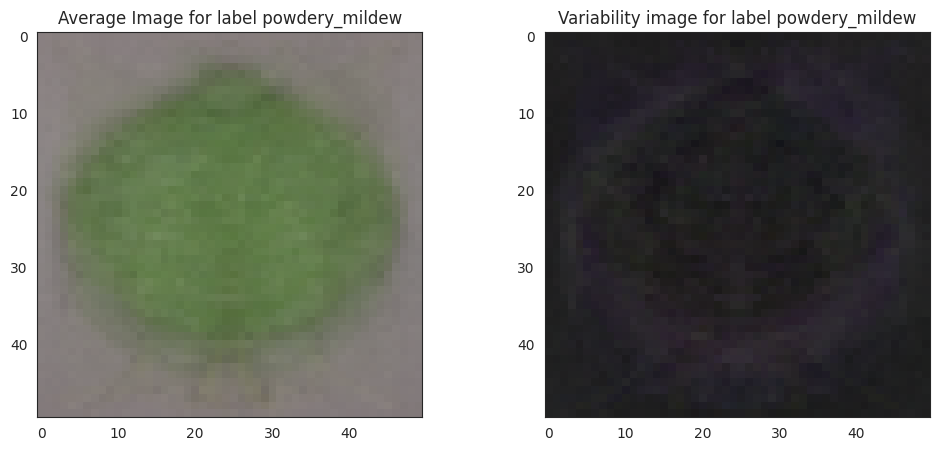

In [48]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True, path_addition='small')


The images are more pixelated, but the main features are still clearly visible.

---